In [13]:
from geoalchemy2 import Geometry, load_spatialite
from flask_caching import Cache
from sqlalchemy import event, Table, insert, func
from sqlalchemy.orm import sessionmaker
import os
from flask import Flask
from quickannotator.db import Project, Image, AnnotationClass, Notification, Tile, Setting, Annotation
from quickannotator.db import db
import large_image
import math
import numpy as np
from shapely.geometry import Point, Polygon, LineString, MultiLineString, MultiPolygon
import random
from shapely.affinity import translate
import json

In [28]:
def insert_project(app, db, name, description, is_dataset_large):
    with app.app_context():
        project = Project(name=name,
                          description=description,
                          is_dataset_large=is_dataset_large)
        db.session.add(project)
        db.session.commit()
        
def insert_image(app, db, project_id, name, path, height, width, dz_tilesize, embedding_coord, group_id, split):
    with app.app_context():
        image = Image(project_id=project_id,
                      name=name,
                      path=path,
                      height=height,
                      width=width,
                      dz_tilesize=dz_tilesize,
                      embedding_coord=embedding_coord,
                      group_id=group_id,
                      split=split)
        db.session.add(image)
        db.session.commit()
        
def insert_annotation_class(app, db, project_id, name, color, magnification, patchsize, tilesize, dl_model_objectref):
    with app.app_context():
        annotation_class = AnnotationClass(project_id=project_id,
                                           name=name,
                                           color=color,
                                           magnification=magnification,
                                           patchsize=patchsize,
                                           tilesize=tilesize,
                                           dl_model_objectref=dl_model_objectref)
        db.session.add(annotation_class)
        db.session.commit()
              
def insert_tile(app, db, image_id, annotation_class_id, geom, seen):
    with app.app_context():
        tile = Tile(image_id=image_id,
                    annotation_class_id=annotation_class_id,
                    geom=geom,
                    seen=seen)
        
        db.session.add(tile)
        db.session.commit()
        
def insert_tiles(app, db, image_id, annotation_class_id):
    image_width, image_height = get_image_dimensions(app, image_id)
    
    with app.app_context():
        tile_size = AnnotationClass.query.filter_by(id=annotation_class_id).first().tilesize
    
    n_cols = math.ceil(image_width / tile_size)
    n_rows = math.ceil(image_height / tile_size)
    
    tiles = []
    for i in range(n_rows):
        for j in range(n_cols):
            t = Tile(image_id=image_id,
                     annotation_class_id=annotation_class_id,
                     geom=f"POLYGON(({j*tile_size} {i*tile_size}, {j*tile_size} {(i+1)*tile_size}, {(j+1)*tile_size} {(i+1)*tile_size}, {(j+1)*tile_size} {i*tile_size}, {j*tile_size} {i*tile_size}))",
                     seen=2
                     )
            tiles.append(t)
    with app.app_context():
        db.session.add_all(tiles)
        db.session.commit()
            
def get_tiles_within_bbox(app, image_id, annotation_class_id, x1y1, x2y2):
    with app.app_context():
        envelope = func.BuildMbr(x1y1[0], x1y1[1], x2y2[0], x2y2[1])
        filter = Tile.geom.ST_intersects(envelope)
        tiles = Tile.query.filter_by(image_id=image_id, annotation_class_id=annotation_class_id).filter(filter).all()
        
    return tiles

def annotations_within_bbox(app, db, table, x1, y1, x2, y2):
    envelope = func.BuildMbr(x1, y1, x2, y2)
    # Right now we are selecting by centroid and not polygon.
    with app.app_context():
        stmt = table.select().where(func.ST_Intersects(table.c.centroid, envelope))
        result = db.session.execute(stmt).fetchall()
        
    return result
  
def get_image_dimensions(app, image_id):
    with app.app_context():
        image = Image.query.filter_by(id=image_id).first()
        return image.width, image.height
        
def create_annotation_table(db, image_id, annotation_class_id, gtpred):
    table_name = f"{image_id}_{annotation_class_id}_{gtpred}_annotation"
    table = Annotation.__table__.to_metadata(db.metadata, name=table_name)
    db.metadata.create_all(bind=db.engine, tables=[table])
            
def generate_random_polygon(max_area=10, centroid=(0, 0)):
    num_points = random.randint(10, 20)  # Polygons need at least 3 points

    # Generate points in polar coordinates
    radii = np.sqrt(np.random.uniform(0, 1, num_points))  # Square root ensures uniform distribution
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)

    # Convert polar coordinates to Cartesian coordinates
    points = [(r * np.cos(a), r * np.sin(a)) for r, a in zip(radii, angles)]

    # Sort points to form a simple polygon
    sorted_points = sorted(points, key=lambda p: np.arctan2(p[1], p[0]))

    # Create a Polygon and scale its area
    polygon = Polygon(sorted_points)

    # Calculate scaling factor
    current_area = polygon.area
    if current_area > 0:
        scaling_factor = np.sqrt(max_area / current_area)
        scaled_points = [(x * scaling_factor, y * scaling_factor) for x, y in sorted_points]
        polygon = Polygon(scaled_points)

    polygon = translate(polygon, xoff=centroid[0], yoff=centroid[1])

    return polygon
    
def generate_annotations(image_width, image_height, n_polygons):
    annotations = []
    for i in range(n_polygons):
        c = Point(np.random.randint(image_width), np.random.randint(image_height))
        
        poly: Polygon = generate_random_polygon(max_area=20, centroid=(c.x, c.y))
        d = {
            "centroid": poly.centroid.wkt,  # Adding SRID=0 for pixel-based coordinates
            "area": poly.area,  # The area of the polygon
            "polygon": poly.wkt,  # Adding SRID=0 for the polygon
            "custom_metrics": json.dumps({"iou": 0.5})  # Convert custom_metrics to a JSON string
        }
        annotations.append(d)
        
    return annotations

def insert_annotations(app, db, image_id, annotation_class_id, gtpred, n):
    table_name = f"{image_id}_{annotation_class_id}_{gtpred}_annotation"

    
    with app.app_context():
        table = Table(table_name, db.metadata, autoload_with=db.engine)
        image = db.session.query(Image).filter_by(id=image_id).first()
        annotations = generate_annotations(image.width, image.height, n)
        
        stmt = insert(table).values(annotations)
        db.session.execute(stmt)
        db.session.commit()
        
    

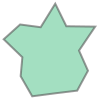

In [9]:
generate_random_polygon(max_area=10, centroid=(0, 0))

In [10]:
generate_annotations(1000, 1000, 1)

[{'centroid': 'POINT (98.27740878350062 926.1301493695511)',
  'area': 19.99999999999991,
  'polygon': 'POLYGON ((95.94043674588909 924.1016311717723, 98.337511578015 924.2354476043885, 98.6613621659211 922.6447221296788, 99.10808160782817 924.7633342909795, 101.82654666646023 923.1834887573208, 100.12538589327721 925, 101.6403553957273 926.6968533786898, 99.99797426964547 927.1852588322463, 98.38771579375975 929.2585301941449, 96.5031622457204 927.8815043752281, 95.53737777709503 926.016717619682, 95.94043674588909 924.1016311717723))',
  'custom_metrics': '{"iou": 0.5}'}]

In [18]:
app = Flask("app")
SearchCache = Cache(config={'CACHE_TYPE': 'SimpleCache'})
SearchCache.init_app(app)
app.config['SQLALCHEMY_DATABASE_URI'] = 'sqlite:///quickannotator.db'
os.environ['SPATIALITE_LIBRARY_PATH'] = '/usr/lib/x86_64-linux-gnu/mod_spatialite.so'

db.app = app
db.init_app(app)
models = [Project, Image, AnnotationClass, Notification, Tile, Setting]
with app.app_context():
    event.listen(db.engine, 'connect', load_spatialite)
    db.drop_all()
    db.metadata.create_all(bind=db.engine, tables=[item.__table__ for item in models])

    create_annotation_table(db, 1, 1, "gt")
    create_annotation_table(db, 1, 2, "gt")

/tmp/ipykernel_50451/705662013.py:83: SAWarning: Table 'annotation' already exists within the given MetaData - not copying.
  table = Annotation.__table__.to_metadata(db.metadata, name=table_name)


In [19]:
insert_project(app, db, 
               name="example_project", 
               description="test", 
               is_dataset_large=False)

full_path = "/home/jackson/research/code/HistoTools/QA_jackson/quickannotator/data/images/1/TCGA-23-2072-01Z-00-DX1.478243FF-BFF0-48A4-ADEA-DE789331A50E.svs"

path = full_path.split("quickannotator/")[1]

slide = large_image.getTileSource(full_path)
insert_image(app, db, 
             project_id=1, 
             name=os.path.basename(path), 
             path=path, 
             height=slide.sizeY, 
             width=slide.sizeX, 
             dz_tilesize=slide.tileWidth,
             embedding_coord="POINT(1 1)", 
             group_id=1, 
             split=1)

insert_annotation_class(app, db,
                        project_id=None,
                        name="Tissue Mask",
                        color="black",
                        magnification=None,
                        patchsize=None,
                        tilesize=None,
                        dl_model_objectref=None)

insert_annotation_class(app, db,
                        project_id=1,
                        name="Tubule",
                        color="red",
                        magnification=10,
                        patchsize=256,
                        tilesize=2048,
                        dl_model_objectref=None)

# insert_annotation(app, db, 1, 1, "gt")

insert_tiles(app, db, image_id=1, annotation_class_id=2)

insert_annotations(app, db, image_id=1, annotation_class_id=2, gtpred="gt", n=1000)

In [9]:
len(get_tiles_within_bbox(app, 1, 2, [0, 0], [41000, 40000]))

420

In [34]:
insert_annotations(app, db, image_id=1, annotation_class_id=2, gtpred="gt", n=10000)

In [35]:
with app.app_context():
    table_name = '1_2_gt_annotation'
    table = Table(table_name, db.metadata, autoload_with=db.engine)
    anns = annotations_within_bbox(app, db, table, 0,0,5000,5000)

In [36]:
anns

[(350, <WKBElement at 0x7fd1f02ec8b0; 0101000020ffffffffce4484ba63495940866d47434fe8a740>, 19.999999999999975, <WKBElement at 0x7fd1f02ed9f0; 0103000020ffffffff0100000010000000be998292be02594047287ad697e7a740c0da860b8cda58402f522952b2e5a740cd0a091244f05840adec0 ... (278 characters truncated) ... 0594043bb16ad9aeca740a492b0859b105940591d8bb090eaa740bcbf59ff5f9b58403cf947dbbceba74084abc37638225840e5c650f4e5e9a740be998292be02594047287ad697e7a740>, '{"iou": 0.5}', datetime.datetime(2024, 10, 24, 21, 49, 27)),
 (618, <WKBElement at 0x7fd1f02ed9c0; 0101000020ffffffff8c1af28664dca1408e36cd79da0f9840>, 20.000000000000377, <WKBElement at 0x7fd18a6bc7c0; 0103000020ffffffff0100000015000000a1cbd3f358daa140fd154816ed0e984078d7dba247d8a140b6866422980a9840d9f2aff722d9a1403fe57 ... (438 characters truncated) ... 7a14094841c7b391b984075aa65e7bfd8a140fc073e1bb91498401fc9138586d6a140af5aadbc8e139840b37af2df65d5a1400000000000109840a1cbd3f358daa140fd154816ed0e9840>, '{"iou": 0.5}', datetime.datetime(2024, 

In [10]:
get_image_dimensions(app, 1)

(127487, 91863)